In [1]:
import torch
import data
import tqdm
import models
import numpy as np
import json
import rgan
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Loading the configuration file, which contains information about the simulated images, and the telescopes they were modelled on, and some model hyperparameters

In [2]:
with open('../config.json') as config_file:
    config = json.load(config_file)

In [3]:
EPOCHS = 125
LR = 5e-5 
IN_SHAPE = config["image_shape_2"] # image dimensions in pixels (assuming square image)
MAGNIFICATION = config["magnification"] # magnitude of each magnification
N_MAG = config["n_magnification"] # number of magnifications required to be performed
DELTA = config["resolution_2"] # LR image resolution
VDL_WEIGHT = 0.75 # initial vdl weight

### Scaling the deflection angle obtained from the SISR models:
The deflection angle values are obtained by design as $\alpha(x,y) \in (0,1)$. They are thus rescaled within appropriate bounds before their use for the purpose of lensing. The coefficients 1 and 2 correspond to the radial $\alpha_r(x,y)$ and tangential $\alpha_t(x,y)$ components of the deflection angle. While $\alpha_r(x,y)$ can ideally be used to contain all the pertaining information, this is no longer required ot be true, as the image space is discretized to pixels. To account for potential inaccuracies brought by this discretization, a (smaller) $\alpha_t(x,y)$ is used for the purpose of potential correction.

In [ ]:
alpha_bounds = [config["alpha_l"],config["alpha_h"]] # bounds for the deflection angle, used in it's scaling

alpha_coeff_1 = torch.tensor(alpha_bounds[1]-alpha_bounds[0]).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_coeff_2 = torch.tensor((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_coeff = torch.concat([alpha_coeff_1, alpha_coeff_2],dim=1)

alpha_disp_1 = torch.tensor(alpha_bounds[0]).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_disp_2 = torch.tensor(-((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling)/2).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_disp = torch.concat([alpha_disp_1, alpha_disp_2],dim=1)

def alpha_scaling(alpha):
    """
    Scales the deflection angle obtained from the model to meaningful bounds
    
    :param alpha: Deflection angle to be scaled
    :return: Scaled deflection angle
    """
    alpha = alpha * alpha_coeff.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    alpha = alpha + alpha_disp.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    return alpha

### Loading the datasets, the dataloaders and performing the required train:validation partitions
A batch size of 5 (merely for computational convenience) is used 5000 images for training, which is divided by an 80:20 validation split. The 5000 images are derived more-or-less equally from the three DM sub-structure classes. There are no high-resolution images loaded as they are not needed !

In [4]:
# We can now load the datasets, combine and shuffle them to have a (close to) homogenous distribution of all sub-structures.
BATCH_SIZE = 5 # Feel free to increase this number; all the training was done on my personal machine, hence, this limitation/

dataset_no_sub = data.LensingDataset('../../Simulations/data_model_2/',['no_sub'],5000)
train_dataset_no_sub, val_dataset_no_sub = torch.utils.data.random_split(dataset_no_sub, [0.8, 0.2])

dataset_axion = data.LensingDataset('../../Simulations/data_model_2/',['axion'],5000)
train_dataset_axion, val_dataset_axion = torch.utils.data.random_split(dataset_axion, [0.8, 0.2])

dataset_cdm = data.LensingDataset('../../Simulations/data_model_2/',['cdm'],5000)
train_dataset_cdm, val_dataset_cdm = torch.utils.data.random_split(dataset_cdm, [0.8, 0.2])

train_dataset = torch.utils.data.ConcatDataset([train_dataset_no_sub, train_dataset_axion, train_dataset_cdm])
val_dataset = torch.utils.data.ConcatDataset([val_dataset_no_sub, val_dataset_axion, val_dataset_cdm])

train_dataset, train_rest = torch.utils.data.random_split(train_dataset, [0.34, 0.66])
val_dataset, val_rest = torch.utils.data.random_split(val_dataset, [0.34, 0.66])

train_dataloader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)
val_dataloader = torch.utils.data.DataLoader(val_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)

# This configuration will load 5000 (low-resolution) images in total, with a 80:20 validation split. 

### Model and physics-inspired loss function loading

In [5]:
# We construct and load the SISR model to the GPU (if available). A loss module is also loaded that performs all the operations required during training.

alpha_model = models.SISR(magnification=MAGNIFICATION, n_mag=N_MAG, residual_depth=config["alpha_depth"], in_channels=1, latent_channel_count=config["latent_channels"]).to(device)
disc_models = [rgan.Discriminator(residual_depth=4, in_shape=IN_SHAPE*MAGNIFICATION*N_MAG, latent_channel_count=8).to(device),
               rgan.Discriminator(residual_depth=4, in_shape=IN_SHAPE, latent_channel_count=8).to(device),
               rgan.Discriminator(residual_depth=4, in_shape=IN_SHAPE//(MAGNIFICATION*N_MAG), latent_channel_count=8).to(device),]
feature_extractor = models.Classifier(in_shape=IN_SHAPE*N_MAG*MAGNIFICATION, in_channels=1).to(device)
truncated_weights = {}
for key,value in torch.load('Feature_weights_2.pt',weights_only=True).items():
    if not key.startswith('fc2'):
        truncated_weights[key] = value
feature_extractor.load_state_dict(truncated_weights)
feature_extractor.eval()
lens_loss = models.SersicProfiler(resolution=DELTA, device=device, discriminators=disc_models, feature_extractor=feature_extractor, sersic_args = [1, 1, 0.25], vdl_weight=VDL_WEIGHT)

opt = torch.optim.Adam(params=alpha_model.parameters(),lr=LR)
alpha_params = sum(p.numel() for p in alpha_model.parameters())
print(f"Generator network parameters: {alpha_params/1e6}1e6")
param_list = []
for model in disc_models:
    param_list += list(model.parameters())
disc_opt = torch.optim.Adam(params=param_list,lr=LR)
for i,model in zip(range(3),disc_models):
    params = sum(p.numel() for p in model.parameters())
    print(f"Discriminator network {i} parameters: {params/1e6}e6")

Generator network parameters: 0.9004221e6
Discriminator network 0 parameters: 0.149425e6
Discriminator network 1 parameters: 0.051121e6
Discriminator network 2 parameters: 0.026545e6


### Performing weight initialization
Several studies have shown that model weight initialization can help in more effective convergence.

In [6]:
# Performing He initialization of the model weights.

def init_weights(m):
    """
    Iterates through all the convolution and fully connected layers of the model to initialize all their weights

    :param m: Model to be initialized
    """
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)  # He initialization
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

alpha_model.apply(init_weights)

SISR(
  (residual_layer_list): ModuleList(
    (0-2): 3 x Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (subpixel_layer_list): ModuleList(
    (0): Sequential(
      (0): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): PixelShuffle(upscale_factor=2)
      (2): ReLU()
    )
  )
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv3): Conv2d(64, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2

### Defining functions that sample the model's performance

In [9]:
def give_random_image(dataset, alpha_model, length, i=None, plot=True):
    """
    Provides a random image for evaluation

    :param dataset: Dataset used
    :param alpha_model: Model used
    :param length: Length of dataset used
    :param i: Index of the selected image, default: 
    :param plot: If true, also plots the source fitting graphs
    :return: original LR image, SR image, reconstructed source
    """
    if i == None:
        i = np.random.randint(low=0,high=length)
    LR = dataset[i].view(1,1,IN_SHAPE,IN_SHAPE).float()
    alpha = alpha_scaling(alpha_model(LR.float().to(device)).detach())
    sersic_profile, LR, source_profile = lens_loss.get_sample(alpha.to(device), LR.to(device), plot)
    LR_im = Image.fromarray(LR.cpu().detach().numpy()[0]*255)
    sersic_im = Image.fromarray(sersic_profile.cpu().detach().numpy()[0]*255)
    source_im = Image.fromarray(source_profile.cpu().detach().numpy()[0]*255)
    return (LR_im, sersic_im, source_im)

def show_random_image(image_tuple):
    """
    Displays the images provided by the give_random_image function
    
    :param image_tuple: Tuple of images returned by the give_random_image function
    """
    LR_im, sersic_im, source_im = image_tuple[0], image_tuple[1], image_tuple[2]
    plot, axes = plt.subplots(1,3)
    plot.set_size_inches(18,6)
    axes[0].imshow(LR_im)
    axes[1].imshow(sersic_im)
    axes[2].imshow(source_im)
    axes[0].set_title("LR_interpolated")
    axes[1].set_title("Image")
    axes[2].set_title("Source Profile")

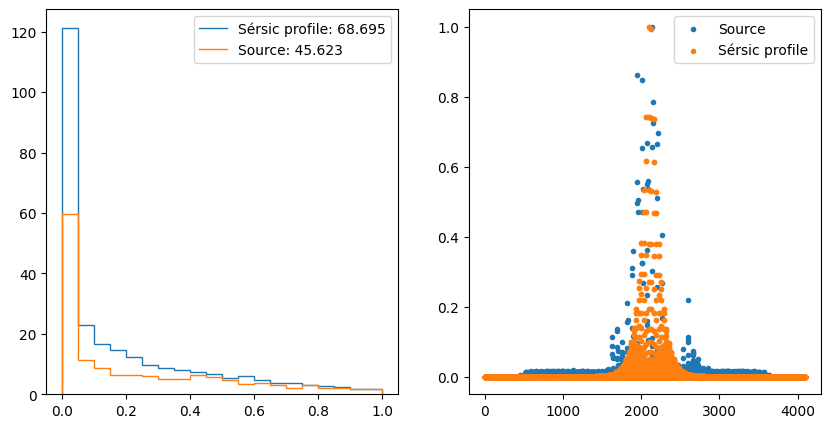

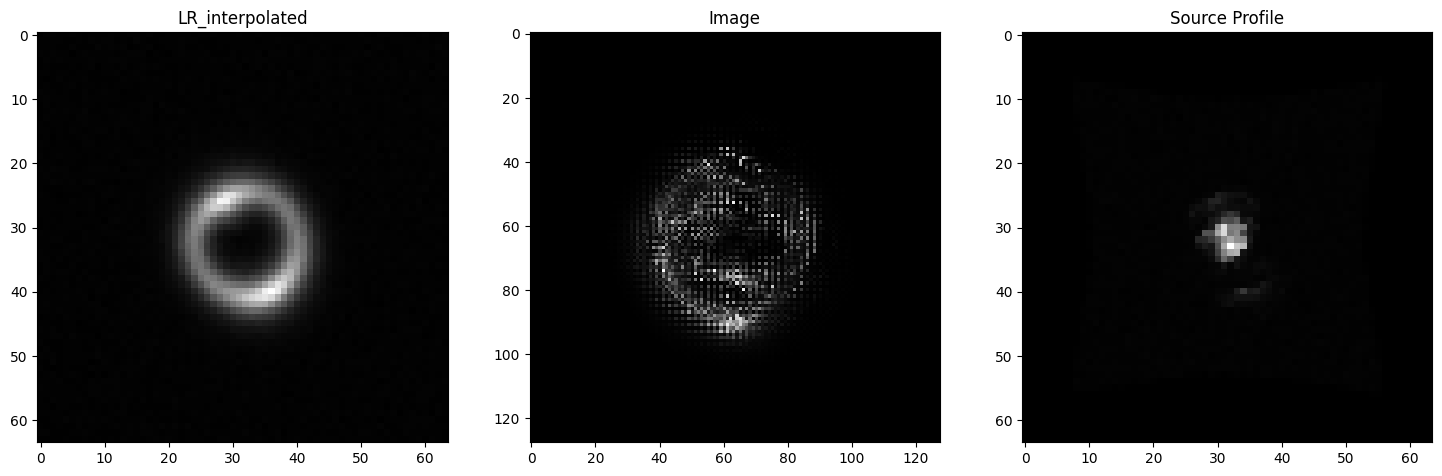

In [10]:
show_random_image(give_random_image(val_dataset, alpha_model, len(val_dataset)))

### The training sequence
The model is trained over the set number of epochs over the training images, and subsequently validated on the validation set. For both, the deflection angle given by the model is used to perform lensing, and is trained in an unsupervised manner by imposing the lensing system's constraints. Since the loss module is composed of various components, each of them is tracked for further study if required. In addition, the training process is stored as GIFs of the SR images, the LR images, and the reconstructed source.

In [11]:
# Training Sequence

best_val_loss = np.inf
best_weights = None
history = {'pre_loss':[],'val_loss':[], 'loss':[], 'images':[], 'lr':[], 'source':[], 'ad_loss':[], 'ad_val_loss':[]} # tracks the train and val losses and training results at each epoch
history_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]} # tracks the individual train loss components at each epoch
for epoch in range(EPOCHS):
    losses = []
    ad_losses = []
    alpha_model.train()
    for model in disc_models:
        model.train()
    individual_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]}
    for i,(x) in enumerate(tqdm.tqdm(train_dataloader, desc=f"Training epoch {epoch+1}")):
        (x) = (x.float().to(device))
        alpha = alpha_model(x)
        alpha = alpha_scaling(alpha)
        loss, history_individual, ad_loss = lens_loss(alpha, x)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(float(loss))
        disc_opt.zero_grad()
        ad_loss.backward()
        disc_opt.step()
        ad_losses.append(float(ad_loss))
        for key in individual_losses.keys():
            if history_individual[key] != []:
                individual_losses[key].append(float(history_individual[key]))
            else:
                individual_losses[key].append(None)
    for key in individual_losses.keys():
        if individual_losses[key][-1] != None:
            history_losses[key].append(np.mean(individual_losses[key]))
        else:
            history_losses[key].append(None)
    if np.isnan(losses[-1]): 
        break
    print(f"Training at epoch {epoch+1}/{EPOCHS}: {np.mean(losses) - float(np.mean(individual_losses['alpha_0']))} at LR={opt.param_groups[0]['lr']}")
    history['loss'].append(np.mean(losses) - float(np.mean(individual_losses['alpha_0'])))
    alpha_model.eval()
    for model in disc_models:
        model.eval()
    individual_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]}
    losses = []
    ad_losses = []
    for i,(x) in enumerate(tqdm.tqdm(val_dataloader, desc=f"Validation epoch {epoch+1}")):
        (x) = (x.float().to(device))
        alpha = alpha_scaling(alpha_model(x))
        val_loss, history_individual, ad_val_loss = lens_loss(alpha, x)
        losses.append(float(val_loss))
        ad_losses.append(float(ad_val_loss))
        for key in individual_losses.keys():
            if history_individual[key] != []:
                individual_losses[key].append(float(history_individual[key]))
            else:
                individual_losses[key].append(None)
    if best_val_loss > np.mean(losses):
        best_val_loss = np.mean(losses)
        best_weights = alpha_model.state_dict()
    history['val_loss'].append(np.mean(losses) - float(np.mean(individual_losses['alpha_0'])))
    print(f"Validation at epoch {epoch+1}/{EPOCHS}: {np.mean(losses) - float(np.mean(individual_losses['alpha_0']))} at LR={opt.param_groups[0]['lr']}")
    lr, im, sr = give_random_image(val_dataset, alpha_model, len(val_dataset),50, plot=False)
    history['lr'].append(lr)
    history['images'].append(im)
    history['source'].append(sr)

Training epoch 1: 100%|██████████| 816/816 [00:50<00:00, 16.15it/s]


Training at epoch 1/125: 0.0190431725452928 at LR=5e-05


Validation epoch 1: 100%|██████████| 204/204 [00:05<00:00, 35.06it/s]


Validation at epoch 1/125: 0.01743351341243468 at LR=5e-05


Training epoch 2: 100%|██████████| 816/816 [00:50<00:00, 16.17it/s]


Training at epoch 2/125: 0.013031850692213465 at LR=5e-05


Validation epoch 2: 100%|██████████| 204/204 [00:05<00:00, 34.38it/s]


Validation at epoch 2/125: 0.010680321777495103 at LR=5e-05


Training epoch 3: 100%|██████████| 816/816 [00:50<00:00, 16.16it/s]


Training at epoch 3/125: 0.01103787401271071 at LR=5e-05


Validation epoch 3: 100%|██████████| 204/204 [00:05<00:00, 34.64it/s]


Validation at epoch 3/125: 0.009891852462554678 at LR=5e-05


Training epoch 4: 100%|██████████| 816/816 [00:50<00:00, 16.06it/s]


Training at epoch 4/125: 0.010454206914622701 at LR=5e-05


Validation epoch 4: 100%|██████████| 204/204 [00:05<00:00, 34.50it/s]


Validation at epoch 4/125: 0.012628071439251595 at LR=5e-05


Training epoch 5: 100%|██████████| 816/816 [00:50<00:00, 16.01it/s]


Training at epoch 5/125: 0.009377327145022506 at LR=5e-05


Validation epoch 5: 100%|██████████| 204/204 [00:05<00:00, 34.67it/s]


Validation at epoch 5/125: 0.012715333625309022 at LR=5e-05


Training epoch 6: 100%|██████████| 816/816 [00:50<00:00, 16.03it/s]


Training at epoch 6/125: 0.008583463360920696 at LR=5e-05


Validation epoch 6: 100%|██████████| 204/204 [00:05<00:00, 34.49it/s]


Validation at epoch 6/125: 0.013059452139571603 at LR=5e-05


Training epoch 7: 100%|██████████| 816/816 [00:50<00:00, 16.02it/s]


Training at epoch 7/125: 0.008072384782637672 at LR=5e-05


Validation epoch 7: 100%|██████████| 204/204 [00:06<00:00, 33.58it/s]


Validation at epoch 7/125: 0.008185196416817751 at LR=5e-05


Training epoch 8: 100%|██████████| 816/816 [00:50<00:00, 16.08it/s]


Training at epoch 8/125: 0.007877269555476733 at LR=5e-05


Validation epoch 8: 100%|██████████| 204/204 [00:06<00:00, 33.68it/s]


Validation at epoch 8/125: 0.007904871759534466 at LR=5e-05


Training epoch 9: 100%|██████████| 816/816 [00:50<00:00, 16.02it/s]


Training at epoch 9/125: 0.007638719109772688 at LR=5e-05


Validation epoch 9: 100%|██████████| 204/204 [00:06<00:00, 33.15it/s]


Validation at epoch 9/125: 0.007326126431900204 at LR=5e-05


Training epoch 10: 100%|██████████| 816/816 [00:51<00:00, 15.92it/s]


Training at epoch 10/125: 0.007290244941353141 at LR=5e-05


Validation epoch 10: 100%|██████████| 204/204 [00:05<00:00, 34.07it/s]


Validation at epoch 10/125: 0.008166912708011474 at LR=5e-05


Training epoch 11: 100%|██████████| 816/816 [00:51<00:00, 15.95it/s]


Training at epoch 11/125: 0.0071489754025641766 at LR=5e-05


Validation epoch 11: 100%|██████████| 204/204 [00:06<00:00, 33.64it/s]


Validation at epoch 11/125: 0.0063252556685577405 at LR=5e-05


Training epoch 12: 100%|██████████| 816/816 [00:51<00:00, 15.95it/s]


Training at epoch 12/125: 0.006928981251001141 at LR=5e-05


Validation epoch 12: 100%|██████████| 204/204 [00:05<00:00, 34.20it/s]


Validation at epoch 12/125: 0.006397942857195934 at LR=5e-05


Training epoch 13: 100%|██████████| 816/816 [00:51<00:00, 15.83it/s]


Training at epoch 13/125: 0.006718882955907498 at LR=5e-05


Validation epoch 13: 100%|██████████| 204/204 [00:06<00:00, 33.27it/s]


Validation at epoch 13/125: 0.006701527587959872 at LR=5e-05


Training epoch 14: 100%|██████████| 816/816 [00:51<00:00, 15.78it/s]


Training at epoch 14/125: 0.006526371060103616 at LR=5e-05


Validation epoch 14: 100%|██████████| 204/204 [00:05<00:00, 34.09it/s]


Validation at epoch 14/125: 0.006831216634999888 at LR=5e-05


Training epoch 15: 100%|██████████| 816/816 [00:51<00:00, 15.82it/s]


Training at epoch 15/125: 0.00633866540167718 at LR=5e-05


Validation epoch 15: 100%|██████████| 204/204 [00:06<00:00, 33.46it/s]


Validation at epoch 15/125: 0.0077183448946943475 at LR=5e-05


Training epoch 16: 100%|██████████| 816/816 [00:51<00:00, 15.92it/s]


Training at epoch 16/125: 0.005825466013002191 at LR=5e-05


Validation epoch 16: 100%|██████████| 204/204 [00:05<00:00, 34.00it/s]


Validation at epoch 16/125: 0.006853418356245931 at LR=5e-05


Training epoch 17: 100%|██████████| 816/816 [00:51<00:00, 15.84it/s]


Training at epoch 17/125: 0.005542291634186518 at LR=5e-05


Validation epoch 17: 100%|██████████| 204/204 [00:06<00:00, 33.55it/s]


Validation at epoch 17/125: 0.005256392892596185 at LR=5e-05


Training epoch 18: 100%|██████████| 816/816 [00:51<00:00, 15.83it/s]


Training at epoch 18/125: 0.005151165422741507 at LR=5e-05


Validation epoch 18: 100%|██████████| 204/204 [00:05<00:00, 34.11it/s]


Validation at epoch 18/125: 0.004656802100476388 at LR=5e-05


Training epoch 19: 100%|██████████| 816/816 [00:51<00:00, 15.91it/s]


Training at epoch 19/125: 0.0048650846423983 at LR=5e-05


Validation epoch 19: 100%|██████████| 204/204 [00:06<00:00, 33.68it/s]


Validation at epoch 19/125: 0.0045803353902609915 at LR=5e-05


Training epoch 20: 100%|██████████| 816/816 [00:51<00:00, 15.83it/s]


Training at epoch 20/125: 0.004805288537218253 at LR=5e-05


Validation epoch 20: 100%|██████████| 204/204 [00:05<00:00, 34.24it/s]


Validation at epoch 20/125: 0.004381836847374764 at LR=5e-05


Training epoch 21: 100%|██████████| 816/816 [00:51<00:00, 15.86it/s]


Training at epoch 21/125: 0.004568682770660221 at LR=5e-05


Validation epoch 21: 100%|██████████| 204/204 [00:06<00:00, 33.27it/s]


Validation at epoch 21/125: 0.004184226649265517 at LR=5e-05


Training epoch 22: 100%|██████████| 816/816 [00:52<00:00, 15.66it/s]


Training at epoch 22/125: 0.004493790737458268 at LR=5e-05


Validation epoch 22: 100%|██████████| 204/204 [00:06<00:00, 33.80it/s]


Validation at epoch 22/125: 0.004434297735547171 at LR=5e-05


Training epoch 23: 100%|██████████| 816/816 [00:52<00:00, 15.64it/s]


Training at epoch 23/125: 0.004414713316638132 at LR=5e-05


Validation epoch 23: 100%|██████████| 204/204 [00:05<00:00, 34.37it/s]


Validation at epoch 23/125: 0.004131110074619452 at LR=5e-05


Training epoch 24: 100%|██████████| 816/816 [00:51<00:00, 15.76it/s]


Training at epoch 24/125: 0.004247376558316106 at LR=5e-05


Validation epoch 24: 100%|██████████| 204/204 [00:06<00:00, 33.44it/s]


Validation at epoch 24/125: 0.004113749597522923 at LR=5e-05


Training epoch 25: 100%|██████████| 816/816 [00:51<00:00, 15.73it/s]


Training at epoch 25/125: 0.0042029698225258694 at LR=5e-05


Validation epoch 25: 100%|██████████| 204/204 [00:06<00:00, 33.28it/s]


Validation at epoch 25/125: 0.004790518790090858 at LR=5e-05


Training epoch 26: 100%|██████████| 816/816 [00:51<00:00, 15.71it/s]


Training at epoch 26/125: 0.0041854528387250635 at LR=5e-05


Validation epoch 26: 100%|██████████| 204/204 [00:06<00:00, 33.47it/s]


Validation at epoch 26/125: 0.003992287031781184 at LR=5e-05


Training epoch 27: 100%|██████████| 816/816 [00:51<00:00, 15.74it/s]


Training at epoch 27/125: 0.004104332958733864 at LR=5e-05


Validation epoch 27: 100%|██████████| 204/204 [00:06<00:00, 33.84it/s]


Validation at epoch 27/125: 0.004004890301182647 at LR=5e-05


Training epoch 28: 100%|██████████| 816/816 [00:51<00:00, 15.76it/s]


Training at epoch 28/125: 0.004196239446173422 at LR=5e-05


Validation epoch 28: 100%|██████████| 204/204 [00:06<00:00, 33.25it/s]


Validation at epoch 28/125: 0.003856636272793562 at LR=5e-05


Training epoch 29: 100%|██████████| 816/816 [00:51<00:00, 15.73it/s]


Training at epoch 29/125: 0.00390857793607603 at LR=5e-05


Validation epoch 29: 100%|██████████| 204/204 [00:06<00:00, 33.53it/s]


Validation at epoch 29/125: 0.004006945240475676 at LR=5e-05


Training epoch 30: 100%|██████████| 816/816 [00:51<00:00, 15.71it/s]


Training at epoch 30/125: 0.003945895441146978 at LR=5e-05


Validation epoch 30: 100%|██████████| 204/204 [00:06<00:00, 33.45it/s]


Validation at epoch 30/125: 0.0040203682794669356 at LR=5e-05


Training epoch 31: 100%|██████████| 816/816 [00:51<00:00, 15.82it/s]


Training at epoch 31/125: 0.00402862425920937 at LR=5e-05


Validation epoch 31: 100%|██████████| 204/204 [00:06<00:00, 33.43it/s]


Validation at epoch 31/125: 0.003823100063920149 at LR=5e-05


Training epoch 32: 100%|██████████| 816/816 [00:51<00:00, 15.70it/s]


Training at epoch 32/125: 0.003950070017262809 at LR=5e-05


Validation epoch 32: 100%|██████████| 204/204 [00:06<00:00, 33.56it/s]


Validation at epoch 32/125: 0.004024208015157366 at LR=5e-05


Training epoch 33: 100%|██████████| 816/816 [00:51<00:00, 15.72it/s]


Training at epoch 33/125: 0.003960453260600951 at LR=5e-05


Validation epoch 33: 100%|██████████| 204/204 [00:06<00:00, 33.65it/s]


Validation at epoch 33/125: 0.003814073754006576 at LR=5e-05


Training epoch 34: 100%|██████████| 816/816 [00:51<00:00, 15.74it/s]


Training at epoch 34/125: 0.003925860041550443 at LR=5e-05


Validation epoch 34: 100%|██████████| 204/204 [00:06<00:00, 33.36it/s]


Validation at epoch 34/125: 0.003751758924587265 at LR=5e-05


Training epoch 35: 100%|██████████| 816/816 [00:51<00:00, 15.70it/s]


Training at epoch 35/125: 0.003985746021784258 at LR=5e-05


Validation epoch 35: 100%|██████████| 204/204 [00:06<00:00, 33.64it/s]


Validation at epoch 35/125: 0.00389122964463918 at LR=5e-05


Training epoch 36: 100%|██████████| 816/816 [00:52<00:00, 15.69it/s]


Training at epoch 36/125: 0.003906148596690721 at LR=5e-05


Validation epoch 36: 100%|██████████| 204/204 [00:06<00:00, 33.23it/s]


Validation at epoch 36/125: 0.0038579730859126748 at LR=5e-05


Training epoch 37: 100%|██████████| 816/816 [00:51<00:00, 15.83it/s]


Training at epoch 37/125: 0.003987405607368405 at LR=5e-05


Validation epoch 37: 100%|██████████| 204/204 [00:06<00:00, 33.89it/s]


Validation at epoch 37/125: 0.0038334714859671543 at LR=5e-05


Training epoch 38: 100%|██████████| 816/816 [00:52<00:00, 15.65it/s]


Training at epoch 38/125: 0.003976129955559622 at LR=5e-05


Validation epoch 38: 100%|██████████| 204/204 [00:06<00:00, 33.38it/s]


Validation at epoch 38/125: 0.0040621194779055705 at LR=5e-05


Training epoch 39: 100%|██████████| 816/816 [00:51<00:00, 15.78it/s]


Training at epoch 39/125: 0.004021247935609198 at LR=5e-05


Validation epoch 39: 100%|██████████| 204/204 [00:05<00:00, 34.14it/s]


Validation at epoch 39/125: 0.004053395930860265 at LR=5e-05


Training epoch 40: 100%|██████████| 816/816 [00:51<00:00, 15.77it/s]


Training at epoch 40/125: 0.004154181251400515 at LR=5e-05


Validation epoch 40: 100%|██████████| 204/204 [00:06<00:00, 33.96it/s]


Validation at epoch 40/125: 0.003955108397919913 at LR=5e-05


Training epoch 41: 100%|██████████| 816/816 [00:52<00:00, 15.64it/s]


Training at epoch 41/125: 0.003916990494283656 at LR=5e-05


Validation epoch 41: 100%|██████████| 204/204 [00:06<00:00, 33.68it/s]


Validation at epoch 41/125: 0.0037624935948235147 at LR=5e-05


Training epoch 42: 100%|██████████| 816/816 [00:52<00:00, 15.67it/s]


Training at epoch 42/125: 0.004004845710833073 at LR=5e-05


Validation epoch 42: 100%|██████████| 204/204 [00:06<00:00, 33.26it/s]


Validation at epoch 42/125: 0.00420219128792786 at LR=5e-05


Training epoch 43: 100%|██████████| 816/816 [00:51<00:00, 15.79it/s]


Training at epoch 43/125: 0.00390880605189915 at LR=5e-05


Validation epoch 43: 100%|██████████| 204/204 [00:06<00:00, 33.58it/s]


Validation at epoch 43/125: 0.0038819583709233016 at LR=5e-05


Training epoch 44: 100%|██████████| 816/816 [00:51<00:00, 15.79it/s]


Training at epoch 44/125: 0.003976559348623542 at LR=5e-05


Validation epoch 44: 100%|██████████| 204/204 [00:06<00:00, 33.58it/s]


Validation at epoch 44/125: 0.003740187599403583 at LR=5e-05


Training epoch 45: 100%|██████████| 816/816 [00:51<00:00, 15.75it/s]


Training at epoch 45/125: 0.0038996523338331226 at LR=5e-05


Validation epoch 45: 100%|██████████| 204/204 [00:06<00:00, 33.68it/s]


Validation at epoch 45/125: 0.003931312483687447 at LR=5e-05


Training epoch 46: 100%|██████████| 816/816 [00:51<00:00, 15.71it/s]


Training at epoch 46/125: 0.00395160335299842 at LR=5e-05


Validation epoch 46: 100%|██████████| 204/204 [00:06<00:00, 33.86it/s]


Validation at epoch 46/125: 0.003709229453342428 at LR=5e-05


Training epoch 47: 100%|██████████| 816/816 [00:51<00:00, 15.83it/s]


Training at epoch 47/125: 0.003941412750482057 at LR=5e-05


Validation epoch 47: 100%|██████████| 204/204 [00:06<00:00, 33.90it/s]


Validation at epoch 47/125: 0.00383641994866433 at LR=5e-05


Training epoch 48: 100%|██████████| 816/816 [00:51<00:00, 15.73it/s]


Training at epoch 48/125: 0.0038772354991855463 at LR=5e-05


Validation epoch 48: 100%|██████████| 204/204 [00:06<00:00, 32.86it/s]


Validation at epoch 48/125: 0.0037379905034493495 at LR=5e-05


Training epoch 49: 100%|██████████| 816/816 [00:51<00:00, 15.81it/s]


Training at epoch 49/125: 0.004719105784697961 at LR=5e-05


Validation epoch 49: 100%|██████████| 204/204 [00:06<00:00, 33.31it/s]


Validation at epoch 49/125: 0.0046295886816498 at LR=5e-05


Training epoch 50: 100%|██████████| 816/816 [00:51<00:00, 15.82it/s]


Training at epoch 50/125: 0.004270993206791544 at LR=5e-05


Validation epoch 50: 100%|██████████| 204/204 [00:06<00:00, 32.78it/s]


Validation at epoch 50/125: 0.004288406272084389 at LR=5e-05


Training epoch 51: 100%|██████████| 816/816 [00:51<00:00, 15.72it/s]


Training at epoch 51/125: 0.004021632090691984 at LR=5e-05


Validation epoch 51: 100%|██████████| 204/204 [00:06<00:00, 33.17it/s]


Validation at epoch 51/125: 0.003817046482022395 at LR=5e-05


Training epoch 52: 100%|██████████| 816/816 [00:52<00:00, 15.68it/s]


Training at epoch 52/125: 0.003930636550934401 at LR=5e-05


Validation epoch 52: 100%|██████████| 204/204 [00:06<00:00, 33.22it/s]


Validation at epoch 52/125: 0.0038681638503547614 at LR=5e-05


Training epoch 53: 100%|██████████| 816/816 [00:51<00:00, 15.81it/s]


Training at epoch 53/125: 0.0039266694279207265 at LR=5e-05


Validation epoch 53: 100%|██████████| 204/204 [00:06<00:00, 33.76it/s]


Validation at epoch 53/125: 0.00389466124590185 at LR=5e-05


Training epoch 54: 100%|██████████| 816/816 [00:52<00:00, 15.67it/s]


Training at epoch 54/125: 0.0038935777706415944 at LR=5e-05


Validation epoch 54: 100%|██████████| 204/204 [00:06<00:00, 33.90it/s]


Validation at epoch 54/125: 0.0037638817759180513 at LR=5e-05


Training epoch 55: 100%|██████████| 816/816 [00:52<00:00, 15.67it/s]


Training at epoch 55/125: 0.0038404766156043693 at LR=5e-05


Validation epoch 55: 100%|██████████| 204/204 [00:05<00:00, 34.51it/s]


Validation at epoch 55/125: 0.0038365581519125653 at LR=5e-05


Training epoch 56: 100%|██████████| 816/816 [00:51<00:00, 15.76it/s]


Training at epoch 56/125: 0.0038322146108696995 at LR=5e-05


Validation epoch 56: 100%|██████████| 204/204 [00:06<00:00, 33.35it/s]


Validation at epoch 56/125: 0.0037236509279133384 at LR=5e-05


Training epoch 57: 100%|██████████| 816/816 [00:51<00:00, 15.80it/s]


Training at epoch 57/125: 0.0038127028458927502 at LR=5e-05


Validation epoch 57: 100%|██████████| 204/204 [00:05<00:00, 34.35it/s]


Validation at epoch 57/125: 0.003704546623910074 at LR=5e-05


Training epoch 58: 100%|██████████| 816/816 [00:52<00:00, 15.64it/s]


Training at epoch 58/125: 0.0038794204604831366 at LR=5e-05


Validation epoch 58: 100%|██████████| 204/204 [00:05<00:00, 34.22it/s]


Validation at epoch 58/125: 0.0036900632851528843 at LR=5e-05


Training epoch 59: 100%|██████████| 816/816 [00:52<00:00, 15.67it/s]


Training at epoch 59/125: 0.0037895669702265873 at LR=5e-05


Validation epoch 59: 100%|██████████| 204/204 [00:06<00:00, 33.16it/s]


Validation at epoch 59/125: 0.0035870658463739115 at LR=5e-05


Training epoch 60: 100%|██████████| 816/816 [00:52<00:00, 15.63it/s]


Training at epoch 60/125: 0.003752457032461796 at LR=5e-05


Validation epoch 60: 100%|██████████| 204/204 [00:05<00:00, 34.17it/s]


Validation at epoch 60/125: 0.003628810695897532 at LR=5e-05


Training epoch 61: 100%|██████████| 816/816 [00:51<00:00, 15.82it/s]


Training at epoch 61/125: 0.003844731814609202 at LR=5e-05


Validation epoch 61: 100%|██████████| 204/204 [00:06<00:00, 33.74it/s]


Validation at epoch 61/125: 0.004051691811422215 at LR=5e-05


Training epoch 62: 100%|██████████| 816/816 [00:52<00:00, 15.62it/s]


Training at epoch 62/125: 0.0037579368787798257 at LR=5e-05


Validation epoch 62: 100%|██████████| 204/204 [00:06<00:00, 33.76it/s]


Validation at epoch 62/125: 0.003810021639676016 at LR=5e-05


Training epoch 63: 100%|██████████| 816/816 [00:52<00:00, 15.64it/s]


Training at epoch 63/125: 0.0038071702687839026 at LR=5e-05


Validation epoch 63: 100%|██████████| 204/204 [00:06<00:00, 33.44it/s]


Validation at epoch 63/125: 0.0037524417281269516 at LR=5e-05


Training epoch 64: 100%|██████████| 816/816 [00:51<00:00, 15.87it/s]


Training at epoch 64/125: 0.0037394034640302006 at LR=5e-05


Validation epoch 64: 100%|██████████| 204/204 [00:06<00:00, 33.69it/s]


Validation at epoch 64/125: 0.0036001800280977404 at LR=5e-05


Training epoch 65: 100%|██████████| 816/816 [00:52<00:00, 15.67it/s]


Training at epoch 65/125: 0.0037533144185384597 at LR=5e-05


Validation epoch 65: 100%|██████████| 204/204 [00:06<00:00, 33.67it/s]


Validation at epoch 65/125: 0.00375110265803432 at LR=5e-05


Training epoch 66: 100%|██████████| 816/816 [00:51<00:00, 15.73it/s]


Training at epoch 66/125: 0.0037059256109048377 at LR=5e-05


Validation epoch 66: 100%|██████████| 204/204 [00:06<00:00, 33.51it/s]


Validation at epoch 66/125: 0.003771610689856222 at LR=5e-05


Training epoch 67: 100%|██████████| 816/816 [00:51<00:00, 15.71it/s]


Training at epoch 67/125: 0.0037066605830606177 at LR=5e-05


Validation epoch 67: 100%|██████████| 204/204 [00:06<00:00, 33.76it/s]


Validation at epoch 67/125: 0.0036376622452984984 at LR=5e-05


Training epoch 68: 100%|██████████| 816/816 [00:52<00:00, 15.55it/s]


Training at epoch 68/125: 0.003656757138207254 at LR=5e-05


Validation epoch 68: 100%|██████████| 204/204 [00:06<00:00, 33.33it/s]


Validation at epoch 68/125: 0.004679350512542799 at LR=5e-05


Training epoch 69: 100%|██████████| 816/816 [00:52<00:00, 15.69it/s]


Training at epoch 69/125: 0.003701427953595104 at LR=5e-05


Validation epoch 69: 100%|██████████| 204/204 [00:06<00:00, 33.82it/s]


Validation at epoch 69/125: 0.0036045172212955854 at LR=5e-05


Training epoch 70: 100%|██████████| 816/816 [00:52<00:00, 15.62it/s]


Training at epoch 70/125: 0.0037723797134936368 at LR=5e-05


Validation epoch 70: 100%|██████████| 204/204 [00:06<00:00, 33.66it/s]


Validation at epoch 70/125: 0.0037006326233762704 at LR=5e-05


Training epoch 71: 100%|██████████| 816/816 [00:51<00:00, 15.83it/s]


Training at epoch 71/125: 0.003744081467220002 at LR=5e-05


Validation epoch 71: 100%|██████████| 204/204 [00:05<00:00, 34.06it/s]


Validation at epoch 71/125: 0.003580232969754577 at LR=5e-05


Training epoch 72: 100%|██████████| 816/816 [00:52<00:00, 15.69it/s]


Training at epoch 72/125: 0.003665113398621507 at LR=5e-05


Validation epoch 72: 100%|██████████| 204/204 [00:06<00:00, 33.19it/s]


Validation at epoch 72/125: 0.0035967653059154085 at LR=5e-05


Training epoch 73: 100%|██████████| 816/816 [00:51<00:00, 15.81it/s]


Training at epoch 73/125: 0.00368390237282238 at LR=5e-05


Validation epoch 73: 100%|██████████| 204/204 [00:06<00:00, 33.61it/s]


Validation at epoch 73/125: 0.0037832653407331596 at LR=5e-05


Training epoch 74: 100%|██████████| 816/816 [00:51<00:00, 15.71it/s]


Training at epoch 74/125: 0.003644160331853474 at LR=5e-05


Validation epoch 74: 100%|██████████| 204/204 [00:06<00:00, 33.59it/s]


Validation at epoch 74/125: 0.0035539973320612944 at LR=5e-05


Training epoch 75: 100%|██████████| 816/816 [00:51<00:00, 15.77it/s]


Training at epoch 75/125: 0.003692080631498909 at LR=5e-05


Validation epoch 75: 100%|██████████| 204/204 [00:06<00:00, 32.86it/s]


Validation at epoch 75/125: 0.003864933274527692 at LR=5e-05


Training epoch 76: 100%|██████████| 816/816 [00:51<00:00, 15.79it/s]


Training at epoch 76/125: 0.00366578278472469 at LR=5e-05


Validation epoch 76: 100%|██████████| 204/204 [00:06<00:00, 33.74it/s]


Validation at epoch 76/125: 0.0035885217438073025 at LR=5e-05


Training epoch 77: 100%|██████████| 816/816 [00:51<00:00, 15.74it/s]


Training at epoch 77/125: 0.004107444208285397 at LR=5e-05


Validation epoch 77: 100%|██████████| 204/204 [00:06<00:00, 33.39it/s]


Validation at epoch 77/125: 0.003848663464190859 at LR=5e-05


Training epoch 78: 100%|██████████| 816/816 [00:52<00:00, 15.64it/s]


Training at epoch 78/125: 0.003901447400744027 at LR=5e-05


Validation epoch 78: 100%|██████████| 204/204 [00:06<00:00, 33.85it/s]


Validation at epoch 78/125: 0.0036942477799682674 at LR=5e-05


Training epoch 79: 100%|██████████| 816/816 [00:51<00:00, 15.78it/s]


Training at epoch 79/125: 0.0037253152457232515 at LR=5e-05


Validation epoch 79: 100%|██████████| 204/204 [00:06<00:00, 33.69it/s]


Validation at epoch 79/125: 0.0036466196310642523 at LR=5e-05


Training epoch 80: 100%|██████████| 816/816 [00:51<00:00, 15.78it/s]


Training at epoch 80/125: 0.003700779941758739 at LR=5e-05


Validation epoch 80: 100%|██████████| 204/204 [00:06<00:00, 33.65it/s]


Validation at epoch 80/125: 0.0036216122492024783 at LR=5e-05


Training epoch 81: 100%|██████████| 816/816 [00:51<00:00, 15.79it/s]


Training at epoch 81/125: 0.003612497649109904 at LR=5e-05


Validation epoch 81: 100%|██████████| 204/204 [00:06<00:00, 33.12it/s]


Validation at epoch 81/125: 0.003621589893751376 at LR=5e-05


Training epoch 82: 100%|██████████| 816/816 [00:51<00:00, 15.71it/s]


Training at epoch 82/125: 0.0037005125569503795 at LR=5e-05


Validation epoch 82: 100%|██████████| 204/204 [00:06<00:00, 33.06it/s]


Validation at epoch 82/125: 0.0036044129890654532 at LR=5e-05


Training epoch 83: 100%|██████████| 816/816 [00:51<00:00, 15.70it/s]


Training at epoch 83/125: 0.003630886697661195 at LR=5e-05


Validation epoch 83: 100%|██████████| 204/204 [00:06<00:00, 33.40it/s]


Validation at epoch 83/125: 0.0036485171605782655 at LR=5e-05


Training epoch 84: 100%|██████████| 816/816 [00:52<00:00, 15.60it/s]


Training at epoch 84/125: 0.0036451124665915153 at LR=5e-05


Validation epoch 84: 100%|██████████| 204/204 [00:06<00:00, 32.66it/s]


Validation at epoch 84/125: 0.003585164726816812 at LR=5e-05


Training epoch 85: 100%|██████████| 816/816 [00:51<00:00, 15.71it/s]


Training at epoch 85/125: 0.0036561060412221946 at LR=5e-05


Validation epoch 85: 100%|██████████| 204/204 [00:06<00:00, 33.59it/s]


Validation at epoch 85/125: 0.003572394993206413 at LR=5e-05


Training epoch 86: 100%|██████████| 816/816 [00:51<00:00, 15.75it/s]


Training at epoch 86/125: 0.0036621133841953117 at LR=5e-05


Validation epoch 86: 100%|██████████| 204/204 [00:06<00:00, 33.81it/s]


Validation at epoch 86/125: 0.003558268148837812 at LR=5e-05


Training epoch 87: 100%|██████████| 816/816 [00:52<00:00, 15.64it/s]


Training at epoch 87/125: 0.0036345319657651574 at LR=5e-05


Validation epoch 87: 100%|██████████| 204/204 [00:06<00:00, 33.40it/s]


Validation at epoch 87/125: 0.0035523597767928104 at LR=5e-05


Training epoch 88: 100%|██████████| 816/816 [00:51<00:00, 15.70it/s]


Training at epoch 88/125: 0.0036374772801840054 at LR=5e-05


Validation epoch 88: 100%|██████████| 204/204 [00:06<00:00, 33.78it/s]


Validation at epoch 88/125: 0.0035768182775320705 at LR=5e-05


Training epoch 89: 100%|██████████| 816/816 [00:51<00:00, 15.72it/s]


Training at epoch 89/125: 0.003670899967712067 at LR=5e-05


Validation epoch 89: 100%|██████████| 204/204 [00:06<00:00, 33.43it/s]


Validation at epoch 89/125: 0.003623873766913426 at LR=5e-05


Training epoch 90: 100%|██████████| 816/816 [00:52<00:00, 15.68it/s]


Training at epoch 90/125: 0.0036548429871247354 at LR=5e-05


Validation epoch 90: 100%|██████████| 204/204 [00:05<00:00, 34.09it/s]


Validation at epoch 90/125: 0.003548786624485408 at LR=5e-05


Training epoch 91: 100%|██████████| 816/816 [00:51<00:00, 15.82it/s]


Training at epoch 91/125: 0.0038828047026803615 at LR=5e-05


Validation epoch 91: 100%|██████████| 204/204 [00:06<00:00, 33.85it/s]


Validation at epoch 91/125: 0.004951126918290267 at LR=5e-05


Training epoch 92: 100%|██████████| 816/816 [00:52<00:00, 15.67it/s]


Training at epoch 92/125: 0.003912625017441242 at LR=5e-05


Validation epoch 92: 100%|██████████| 204/204 [00:06<00:00, 33.11it/s]


Validation at epoch 92/125: 0.0036383631594100164 at LR=5e-05


Training epoch 93: 100%|██████████| 816/816 [00:51<00:00, 15.71it/s]


Training at epoch 93/125: 0.0036584941404084123 at LR=5e-05


Validation epoch 93: 100%|██████████| 204/204 [00:06<00:00, 33.54it/s]


Validation at epoch 93/125: 0.0036335915224923404 at LR=5e-05


Training epoch 94: 100%|██████████| 816/816 [00:52<00:00, 15.65it/s]


Training at epoch 94/125: 0.003660364133347506 at LR=5e-05


Validation epoch 94: 100%|██████████| 204/204 [00:06<00:00, 33.24it/s]


Validation at epoch 94/125: 0.003572136260153653 at LR=5e-05


Training epoch 95: 100%|██████████| 816/816 [00:52<00:00, 15.69it/s]


Training at epoch 95/125: 0.003644947699178695 at LR=5e-05


Validation epoch 95: 100%|██████████| 204/204 [00:06<00:00, 33.90it/s]


Validation at epoch 95/125: 0.003563594125700868 at LR=5e-05


Training epoch 96: 100%|██████████| 816/816 [00:51<00:00, 15.79it/s]


Training at epoch 96/125: 0.0036878632020613854 at LR=5e-05


Validation epoch 96: 100%|██████████| 204/204 [00:06<00:00, 33.29it/s]


Validation at epoch 96/125: 0.0035899303974492444 at LR=5e-05


Training epoch 97: 100%|██████████| 816/816 [00:51<00:00, 15.82it/s]


Training at epoch 97/125: 0.003672897092602558 at LR=5e-05


Validation epoch 97: 100%|██████████| 204/204 [00:06<00:00, 32.80it/s]


Validation at epoch 97/125: 0.0036407507343706215 at LR=5e-05


Training epoch 98: 100%|██████████| 816/816 [00:51<00:00, 15.76it/s]


Training at epoch 98/125: 0.0036109679082680186 at LR=5e-05


Validation epoch 98: 100%|██████████| 204/204 [00:06<00:00, 33.47it/s]


Validation at epoch 98/125: 0.003618862392898996 at LR=5e-05


Training epoch 99: 100%|██████████| 816/816 [00:51<00:00, 15.75it/s]


Training at epoch 99/125: 0.003650172457056732 at LR=5e-05


Validation epoch 99: 100%|██████████| 204/204 [00:06<00:00, 33.88it/s]


Validation at epoch 99/125: 0.0036154718303199234 at LR=5e-05


Training epoch 100: 100%|██████████| 816/816 [00:52<00:00, 15.60it/s]


Training at epoch 100/125: 0.0036378761012433557 at LR=5e-05


Validation epoch 100: 100%|██████████| 204/204 [00:06<00:00, 33.65it/s]


Validation at epoch 100/125: 0.003561128130897094 at LR=5e-05


Training epoch 101: 100%|██████████| 816/816 [00:51<00:00, 15.75it/s]


Training at epoch 101/125: 0.003616323189050366 at LR=5e-05


Validation epoch 101: 100%|██████████| 204/204 [00:06<00:00, 33.10it/s]


Validation at epoch 101/125: 0.0036620892208827404 at LR=5e-05


Training epoch 102: 100%|██████████| 816/816 [00:52<00:00, 15.69it/s]


Training at epoch 102/125: 0.003584203180556263 at LR=5e-05


Validation epoch 102: 100%|██████████| 204/204 [00:06<00:00, 33.53it/s]


Validation at epoch 102/125: 0.003583117327983856 at LR=5e-05


Training epoch 103: 100%|██████████| 816/816 [00:51<00:00, 15.75it/s]


Training at epoch 103/125: 0.003621421106015309 at LR=5e-05


Validation epoch 103: 100%|██████████| 204/204 [00:06<00:00, 32.98it/s]


Validation at epoch 103/125: 0.0035341941139788603 at LR=5e-05


Training epoch 104: 100%|██████████| 816/816 [00:52<00:00, 15.58it/s]


Training at epoch 104/125: 0.0036696659381228597 at LR=5e-05


Validation epoch 104: 100%|██████████| 204/204 [00:06<00:00, 33.74it/s]


Validation at epoch 104/125: 0.003652461859803902 at LR=5e-05


Training epoch 105: 100%|██████████| 816/816 [00:52<00:00, 15.68it/s]


Training at epoch 105/125: 0.0035992139052598527 at LR=5e-05


Validation epoch 105: 100%|██████████| 204/204 [00:06<00:00, 33.05it/s]


Validation at epoch 105/125: 0.0035241791466593415 at LR=5e-05


Training epoch 106: 100%|██████████| 816/816 [00:51<00:00, 15.75it/s]


Training at epoch 106/125: 0.003670390381040645 at LR=5e-05


Validation epoch 106: 100%|██████████| 204/204 [00:06<00:00, 33.96it/s]


Validation at epoch 106/125: 0.003585761789473312 at LR=5e-05


Training epoch 107: 100%|██████████| 816/816 [00:52<00:00, 15.55it/s]


Training at epoch 107/125: 0.003589928258745703 at LR=5e-05


Validation epoch 107: 100%|██████████| 204/204 [00:06<00:00, 33.82it/s]


Validation at epoch 107/125: 0.00357797768425799 at LR=5e-05


Training epoch 108: 100%|██████████| 816/816 [00:52<00:00, 15.62it/s]


Training at epoch 108/125: 0.0035783170256478364 at LR=5e-05


Validation epoch 108: 100%|██████████| 204/204 [00:05<00:00, 34.15it/s]


Validation at epoch 108/125: 0.003643831014165235 at LR=5e-05


Training epoch 109: 100%|██████████| 816/816 [00:51<00:00, 15.80it/s]


Training at epoch 109/125: 0.003576877430924808 at LR=5e-05


Validation epoch 109: 100%|██████████| 204/204 [00:06<00:00, 33.53it/s]


Validation at epoch 109/125: 0.003592488125957293 at LR=5e-05


Training epoch 110: 100%|██████████| 816/816 [00:51<00:00, 15.80it/s]


Training at epoch 110/125: 0.003788388694802587 at LR=5e-05


Validation epoch 110: 100%|██████████| 204/204 [00:06<00:00, 33.87it/s]


Validation at epoch 110/125: 0.003959706091657555 at LR=5e-05


Training epoch 111: 100%|██████████| 816/816 [00:52<00:00, 15.68it/s]


Training at epoch 111/125: 0.0036555129919696467 at LR=5e-05


Validation epoch 111: 100%|██████████| 204/204 [00:06<00:00, 33.49it/s]


Validation at epoch 111/125: 0.0036239612744276535 at LR=5e-05


Training epoch 112: 100%|██████████| 816/816 [00:52<00:00, 15.65it/s]


Training at epoch 112/125: 0.003656247635637341 at LR=5e-05


Validation epoch 112: 100%|██████████| 204/204 [00:06<00:00, 33.75it/s]


Validation at epoch 112/125: 0.0035096844036232536 at LR=5e-05


Training epoch 113: 100%|██████████| 816/816 [00:52<00:00, 15.69it/s]


Training at epoch 113/125: 0.0036070763266716132 at LR=5e-05


Validation epoch 113: 100%|██████████| 204/204 [00:06<00:00, 32.93it/s]


Validation at epoch 113/125: 0.003556664857052394 at LR=5e-05


Training epoch 114: 100%|██████████| 816/816 [00:51<00:00, 15.82it/s]


Training at epoch 114/125: 0.00361501496416738 at LR=5e-05


Validation epoch 114: 100%|██████████| 204/204 [00:05<00:00, 34.28it/s]


Validation at epoch 114/125: 0.0038959968893037765 at LR=5e-05


Training epoch 115: 100%|██████████| 816/816 [00:51<00:00, 15.80it/s]


Training at epoch 115/125: 0.0036310834561043203 at LR=5e-05


Validation epoch 115: 100%|██████████| 204/204 [00:06<00:00, 33.25it/s]


Validation at epoch 115/125: 0.0035245158340366485 at LR=5e-05


Training epoch 116: 100%|██████████| 816/816 [00:52<00:00, 15.67it/s]


Training at epoch 116/125: 0.0036889252260866043 at LR=5e-05


Validation epoch 116: 100%|██████████| 204/204 [00:06<00:00, 33.27it/s]


Validation at epoch 116/125: 0.003530237649387096 at LR=5e-05


Training epoch 117: 100%|██████████| 816/816 [00:51<00:00, 15.81it/s]


Training at epoch 117/125: 0.0035763491368390322 at LR=5e-05


Validation epoch 117: 100%|██████████| 204/204 [00:06<00:00, 33.29it/s]


Validation at epoch 117/125: 0.003550459239026988 at LR=5e-05


Training epoch 118: 100%|██████████| 816/816 [00:51<00:00, 15.70it/s]


Training at epoch 118/125: 0.003576028449863182 at LR=5e-05


Validation epoch 118: 100%|██████████| 204/204 [00:06<00:00, 33.17it/s]


Validation at epoch 118/125: 0.0035528707808493085 at LR=5e-05


Training epoch 119: 100%|██████████| 816/816 [00:51<00:00, 15.73it/s]


Training at epoch 119/125: 0.003615614387301463 at LR=5e-05


Validation epoch 119: 100%|██████████| 204/204 [00:06<00:00, 33.60it/s]


Validation at epoch 119/125: 0.003596218225663738 at LR=5e-05


Training epoch 120: 100%|██████████| 816/816 [00:51<00:00, 15.76it/s]


Training at epoch 120/125: 0.0035875877744247723 at LR=5e-05


Validation epoch 120: 100%|██████████| 204/204 [00:05<00:00, 34.12it/s]


Validation at epoch 120/125: 0.003557691419629526 at LR=5e-05


Training epoch 121: 100%|██████████| 816/816 [00:52<00:00, 15.66it/s]


Training at epoch 121/125: 0.0036598111037164922 at LR=5e-05


Validation epoch 121: 100%|██████████| 204/204 [00:06<00:00, 33.31it/s]


Validation at epoch 121/125: 0.0035146035294804047 at LR=5e-05


Training epoch 122: 100%|██████████| 816/816 [00:52<00:00, 15.69it/s]


Training at epoch 122/125: 0.003588381558859278 at LR=5e-05


Validation epoch 122: 100%|██████████| 204/204 [00:06<00:00, 33.83it/s]


Validation at epoch 122/125: 0.003573805843188893 at LR=5e-05


Training epoch 123: 100%|██████████| 816/816 [00:51<00:00, 15.71it/s]


Training at epoch 123/125: 0.0035796565945002286 at LR=5e-05


Validation epoch 123: 100%|██████████| 204/204 [00:06<00:00, 33.44it/s]


Validation at epoch 123/125: 0.004279720721088405 at LR=5e-05


Training epoch 124: 100%|██████████| 816/816 [00:52<00:00, 15.58it/s]


Training at epoch 124/125: 0.003632728453250785 at LR=5e-05


Validation epoch 124: 100%|██████████| 204/204 [00:06<00:00, 33.19it/s]


Validation at epoch 124/125: 0.0036032637188898164 at LR=5e-05


Training epoch 125: 100%|██████████| 816/816 [00:51<00:00, 15.81it/s]


Training at epoch 125/125: 0.003563300683405638 at LR=5e-05


Validation epoch 125: 100%|██████████| 204/204 [00:06<00:00, 33.03it/s]

Validation at epoch 125/125: 0.003606931423693074 at LR=5e-05


Text(0.5, 1.0, 'Individual losses plot')

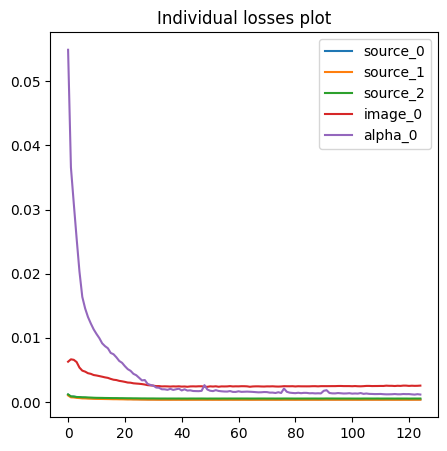

In [12]:
plot, axes = plt.subplots(1,1)
plot.set_size_inches(5,5)
for key in list(individual_losses.keys()):
    axes.plot(history_losses[key],label=key)
axes.legend()
axes.set_title('Individual losses plot')

Text(0.5, 1.0, 'Train and val losses')

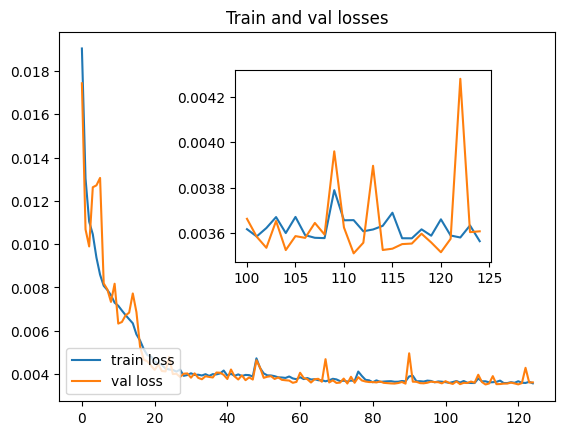

In [13]:
plot, axes = plt.subplots()
axes.plot(history['loss'],label='train loss')
axes.plot(history['val_loss'],label='val loss')
axes_2 = plot.add_axes([0.4,0.4,0.4,0.4])
axes_2.plot(range(int(0.8*EPOCHS),EPOCHS),history['loss'][int(0.8*EPOCHS):],label='train loss')
axes_2.plot(range(int(0.8*EPOCHS),EPOCHS),history['val_loss'][int(0.8*EPOCHS):],label='val loss')
# axes_2.set_xticks([int(0.8*EPOCHS), EPOCHS])
axes.legend(loc='lower left')
axes.set_title('Train and val losses')

### Loading the best performing model

In [14]:
# Loads the model weights at the lowest validation score

alpha_model.load_state_dict(best_weights)
print(best_val_loss)

0.004651420481512141


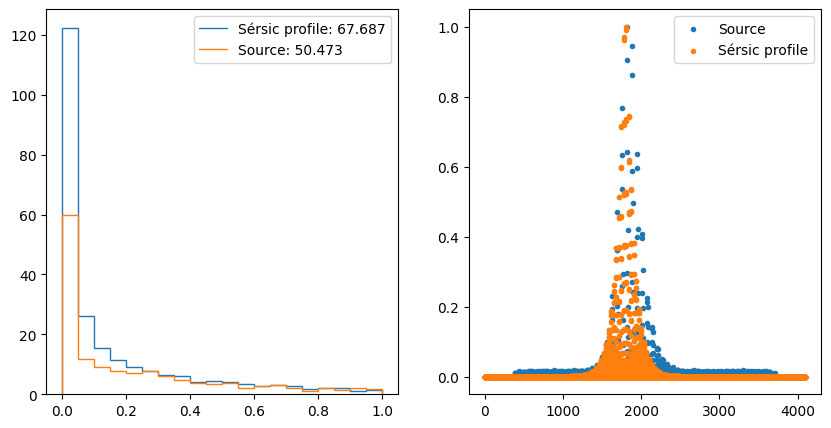

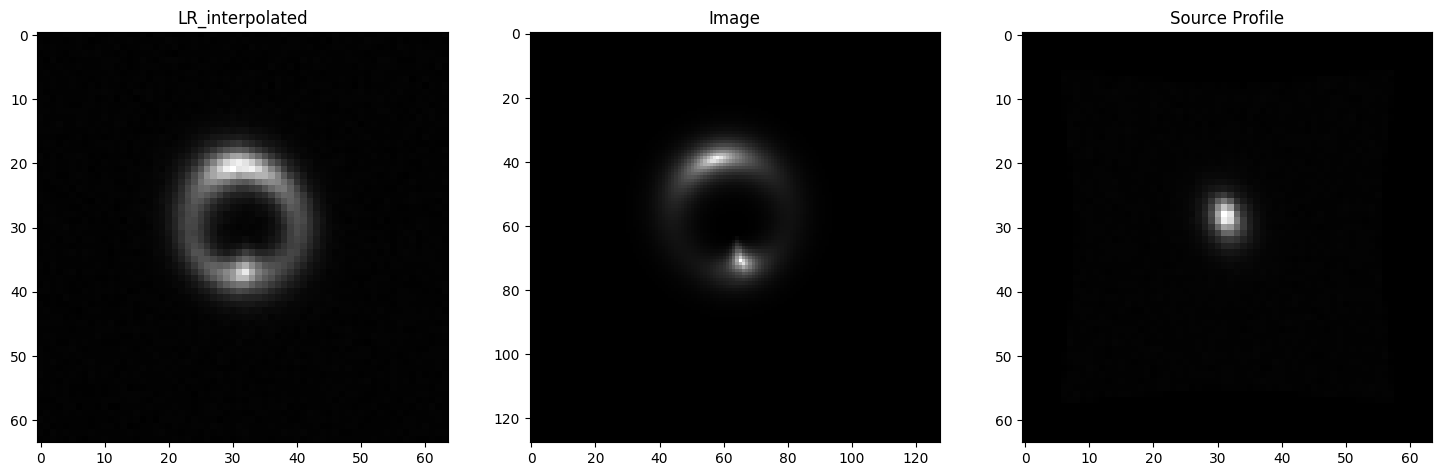

In [15]:
show_random_image(give_random_image(val_dataset, alpha_model, len(val_dataset)))

In [16]:
# Saves the training progress as GIFs of the reconstructed source and the super-resolved images

history['images'][0].save('images.gif',save_all=True, append_images = history['images'][1:], optimize=False, duration=100, loop=0)
history['lr'][0].save('lr.gif',save_all=True, append_images = history['lr'][1:], optimize=False, duration=100, loop=0)
history['source'][0].save('source.gif',save_all=True, append_images = history['source'][1:], optimize=False, duration=100, loop=0)

In [17]:
torch.save(best_weights, 'Weights_2.pt')